Import dos pacotes

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV

# configs do Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

Import dos dados

In [2]:
metadados = pd.read_excel('metadata.xlsx')
metadados

,Feature,Feature_Type,Description
0,age,numeric,age of a person
1,job,"Categorical,nominal","type of job ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')"
2,marital,"categorical,nominal","marital status ('divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)"
3,education,"categorical,nominal","('basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')"
4,default,"categorical,nominal","has credit in default? ('no','yes','unknown')"
5,housing,"categorical,nominal","has housing loan? ('no','yes','unknown')"
6,loan,"categorical,nominal","has personal loan? ('no','yes','unknown')"
7,contact,"categorical,nominal","contact communication type ('cellular','telephone')"
8,month,"categorical,ordinal","last contact month of year ('jan', 'feb', 'mar', …, 'nov', 'dec')"
9,dayofweek,"categorical,ordinal","last contact day of the week ('mon','tue','wed','thu','fri')"


In [3]:
dados = pd.read_csv('new_train.csv', sep=',')
dados

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,28,services,single,high.school,no,yes,no,cellular,jul,tue,192,1,999,0,nonexistent,no
32946,52,technician,married,professional.course,no,yes,no,cellular,nov,fri,64,1,999,1,failure,no
32947,54,admin.,married,basic.9y,no,no,yes,cellular,jul,mon,131,4,999,0,nonexistent,no
32948,29,admin.,married,university.degree,no,no,no,telephone,may,fri,165,1,999,0,nonexistent,no


Removendo o 'y' e adaptando a base para um problema regressor

In [4]:
dados = dados.drop(columns=['y']).copy()
dados.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent


Feature engineering - criação de nova variável
(Objetivo: predizer a variável 'age')

In [5]:
dados['difficulty'] = -1 # desconhecido
dados.loc[(dados['poutcome'] == 'success') & (dados['previous'].between(0, 4)), 'difficulty'] = 0 # fácil e médio
dados.loc[(dados['poutcome'] == 'success') & (dados['previous'].between(5, 8)), 'difficulty'] = 1 # difícil e muito difícil
dados.loc[(dados['poutcome'] == 'failure'), 'difficulty'] = 2 # impossível
dados['difficulty'].value_counts()

-1    28416
 2     3429
 0     1088
 1       17
Name: difficulty, dtype: int64

In [6]:
dados.corr()

,age,duration,campaign,pdays,previous,difficulty
age,1.000000,-0.001841,0.003302,-0.032011,0.020670,0.002181
duration,-0.001841,1.000000,-0.075663,-0.047127,0.022538,-0.003248
campaign,0.003302,-0.075663,1.000000,0.053795,-0.079051,-0.078568
pdays,-0.032011,-0.047127,0.053795,1.000000,-0.589601,-0.184078
previous,0.020670,0.022538,-0.079051,-0.589601,1.000000,0.783286
difficulty,0.002181,-0.003248,-0.078568,-0.184078,0.783286,1.000000


In [7]:
dados.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'difficulty'],
      dtype='object')

In [8]:
# Verificando se existem dados nulos
dados.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
difficulty     0
dtype: int64

In [9]:
dados.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
difficulty      int64
dtype: object

Separar a target do df de treinamento/teste (validação)

In [10]:
explicativas = dados.drop(columns=['age']).copy()
explicativas

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,difficulty
0,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,-1
1,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,2
2,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,-1
3,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,-1
4,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32945,services,single,high.school,no,yes,no,cellular,jul,tue,192,1,999,0,nonexistent,-1
32946,technician,married,professional.course,no,yes,no,cellular,nov,fri,64,1,999,1,failure,2
32947,admin.,married,basic.9y,no,no,yes,cellular,jul,mon,131,4,999,0,nonexistent,-1
32948,admin.,married,university.degree,no,no,no,telephone,may,fri,165,1,999,0,nonexistent,-1


In [11]:
var_resp = dados['age'].copy()
var_resp

0        49
1        37
2        78
3        36
4        59
         ..
32945    28
32946    52
32947    54
32948    29
32949    35
Name: age, Length: 32950, dtype: int64

/home/mbaltar/miniconda3/envs/curso_modal/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age'>

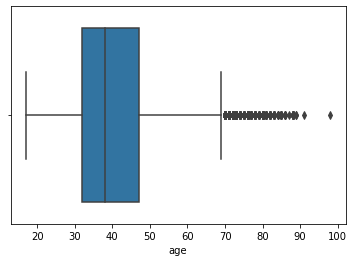

In [13]:
sns.boxplot(var_resp)

Tratamento das variáveis categóricas

In [14]:
expl_cat = explicativas[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']]

# Separando também as numéricas
expl_num = explicativas[['duration', 'campaign', 'pdays', 'difficulty']]

In [15]:
expl_cat_encoding = pd.get_dummies(expl_cat, prefix_sep='_', columns=expl_cat.columns, drop_first=True)
expl_cat_encoding.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [17]:
explicativas_tratadas = expl_num.merge(expl_cat_encoding, left_index=True, right_index=True)
explicativas_tratadas.head()

,duration,campaign,pdays,difficulty,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,227,4,999,-1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,202,2,999,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1148,1,999,-1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,120,2,999,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,368,2,999,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


Feature Selection

In [18]:
# Seleção de vars categóricas

dt = DecisionTreeRegressor(random_state=42)
tree_selector = SelectFromModel(dt, max_features=5)
tree_selector.fit(expl_cat_encoding, var_resp)
tree_support = tree_selector.get_support()
tree_feature = expl_cat_encoding.loc[:, tree_support].columns.tolist()
tree_feature

['job_retired', 'marital_single', 'default_unknown', 'housing_yes', 'loan_yes']

In [19]:
# Seleção das variáveis numéricas

rf = RandomForestRegressor(random_state=42)
rfe_selector = RFE(estimator=rf, n_features_to_select=2)
rfe_selector.fit(expl_num, var_resp)
rfe_support = rfe_selector.get_support()
rfe_feature = expl_num.loc[:, rfe_support].columns.tolist()
rfe_feature

['duration', 'campaign']

In [21]:
# Base a ser considerada na análise
expl_num_feature = expl_num[['duration', 'campaign']]
expl_cat_feature = expl_cat[['job', 'marital', 'default', 'housing', 'loan']]
expl_cat_feature = pd.get_dummies(expl_cat_feature, prefix_sep='_', columns=expl_cat_feature.columns, drop_first=True)

In [22]:
explicativas_modelagem = expl_num_feature.merge(expl_cat_feature, left_index=True, right_index=True)
explicativas_modelagem.head()

,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,227,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,202,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1148,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,120,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,368,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Quebrar entre treino e teste

In [23]:
x_treino, x_teste, y_treino, y_teste = train_test_split(explicativas_modelagem, var_resp, test_size=0.3, random_state=42)

Treinamento dos modelos

In [25]:
tree = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)

tree_cross = cross_val_score(estimator=tree, X=x_treino, y=y_treino, cv=3, scoring=make_scorer(mean_absolute_error))
tree_cross

array([9.2936446 , 9.20231313, 9.22613163])

In [26]:
tree.fit(x_treino, y_treino)

DecisionTreeRegressor(random_state=42)

In [27]:
mean_absolute_error(y_treino, tree.predict(x_treino))

0.8620767396488187

In [33]:
mean_absolute_error(y_teste, tree.predict(x_teste))

9.079376159163715

In [28]:
rf.fit(x_treino, y_treino)

RandomForestRegressor(random_state=42)

In [30]:
mean_absolute_error(y_treino, rf.predict(x_treino))

3.058313480062342

In [34]:
mean_absolute_error(y_teste, rf.predict(x_teste))

7.252896887710165

In [29]:
gb.fit(x_treino, y_treino)

GradientBoostingRegressor(random_state=42)

In [31]:
mean_absolute_error(y_treino, gb.predict(x_treino))

6.57986000531845

In [35]:
mean_absolute_error(y_teste, gb.predict(x_teste))

6.637892323582641

In [ ]:
# O GradienteBoosting é o que apresentou menor diferença nos erros entre os conjuntos de treino e teste

Tunning de hiperparâmetros

In [37]:
# exemplo com Random Forest Regressor
rf_grid_dict = {
    'n_estimators':[50, 100, 200],
    'bootstrap':[True, False],
    'random_state':[42]
}
rf_grid = GridSearchCV(rf, rf_grid_dict, cv=2, scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [38]:
rf_grid.fit(x_treino, y_treino)

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [39]:
rf_grid.best_params_

{'bootstrap': True, 'n_estimators': 200, 'random_state': 42}

In [40]:
rf_grid.best_score_

-7.2717619720221744

In [41]:
mean_absolute_error(y_teste, rf_grid.predict(x_teste))

7.236136896856586

In [46]:
# Fazendo tunning com o modelo do GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=42)
gb_grid_dict = {
    'max_depth':[1, 3, 8],
    'n_estimators':[10, 20],
    'random_state':[42]
}
gb_grid = GridSearchCV(gb, gb_grid_dict, scoring = make_scorer(mean_absolute_error, greater_is_better=False), cv=2, n_jobs=3)

In [47]:
gb_grid.fit(x_treino, y_treino)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=3,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [48]:
gb_grid.best_params_

{'max_depth': 8, 'n_estimators': 20, 'random_state': 42}

In [49]:
gb_grid.best_score_

-6.751334227515821

Métricas

In [50]:
mean_squared_error(y_treino, gb_grid.predict(x_treino), squared=True)

63.677772810835435

In [51]:
mean_squared_error(y_teste, gb_grid.predict(x_teste), squared=True)

68.68349148754422

Serializar o modelo

In [52]:
# As bibliotecas abaixo são redundantes, usando as duas por questões de didática

import pickle
import joblib

In [54]:
with open('gb_pickle.pkl', 'wb') as modelo:
    pickle.dump(gb_grid, modelo)

In [55]:
joblib.dump(gb_grid, 'gb_joblib.pkl')

['gb_joblib.pkl']

In [56]:
# Fazendo a leitura dos modelos serializados

# Com pickle
modelo_no_pickle = pickle.load(open('gb_pickle.pkl', 'rb'))

In [57]:
modelo_no_pickle

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=3,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [58]:
# Com joblib
modelo_no_joblib = joblib.load('gb_joblib.pkl')
modelo_no_joblib

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=3,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

Prevendo os valores usando o modelo

In [59]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [60]:
explicativas_modelagem.head()

,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,227,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,202,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1148,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,120,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,368,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
# Prevendo para a primeira linha (no dataset original a idade = 49. Vamos ver o que o modelo prediz)
teste_predicao = explicativas_modelagem.iloc[[0]]

In [64]:
modelo_no_joblib.predict(teste_predicao)

array([42.45162562])

In [66]:
mean_absolute_error([49], [42.45])

6.549999999999997

In [68]:
# Prevendo para os 5 primeiros registros
teste_predicao = explicativas_modelagem.iloc[:5,:]
teste_predicao

,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,227,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,202,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1148,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,120,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,368,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
df.iloc[:5,0]

0    49
1    37
2    78
3    36
4    59
Name: age, dtype: int64

In [73]:
predicoes = modelo_no_joblib.predict(teste_predicao)
predicoes

array([42.45162562, 40.64432024, 62.15552057, 40.08563763, 66.02690592])

In [74]:
mean_absolute_error(df.iloc[:5, 0], predicoes)

7.429943516749001